### Prepare
Check environment. Install packages if in Colab.


In [ ]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !pip3 install opencv3
    !pip3 install simplejson
    !pip3 install matplotlib
    !pip3 install iopath
    !pip install common
    !pip install fvcore
    !pip install av
    !rm -rf visualization mae
    !git clone https://github.com/haooooooqi/visualization.git
    !mv visualization mae
    sys.path.append('./mae')
    !rm -rf slowfast SlowFast
    !git clone https://github.com/facebookresearch/SlowFast.git
    !mv SlowFast slowfast
    sys.path.append('./slowfast')
else:
    sys.path.append('..')
import models_mae

Running in Colab.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement opencv3 (from versions: none)
ERROR: No matching distribution found for opencv3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'visualization'...
remote: Enumera

In [ ]:
!pip install scikit-video
import skvideo.io
import scipy
import tqdm
import os
import os.path as osp
import argparse
import urllib.request
import pandas as pd
from multiprocessing import Pool
from tqdm import tqdm
import tarfile
!pip install PyTube
import pytube


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#install pytorchvideo cause it not working
!git clone https://github.com/facebookresearch/pytorchvideo.git
sys.path.append('./pytorchvideo')
!pip install -e /content/pytorchvideo

Cloning into 'pytorchvideo'...
remote: Enumerating objects: 2458, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 2458 (delta 97), reused 156 (delta 85), pack-reused 2281
Receiving objects: 100% (2458/2458), 6.06 MiB | 28.62 MiB/s, done.
Resolving deltas: 100% (1367/1367), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/pytorchvideo
  Preparing metadata (setup.py) ... done
  Running setup.py develop for pytorchvideo


### Define utils

Load a small fraction (up to 100 videos) of the Kinetics 400 dataset using code from https://github.com/chi0tzp/KineticX-Downloader

In [ ]:
# load videos
# From https://github.com/chi0tzp/KineticX-Downloader

global video_output_dir, error_file
errors = 0

def download_video(youtube_id):
    """Download video from YouTube using PyTube.
    Args:
        youtube_id (str): Youtube id (https://www.youtube.com/watch?v=<youtube_id>)
    """
    global error_file, errors
    try:
        youtube = pytube.YouTube('https://www.youtube.com/watch?v=' + youtube_id)
        video = youtube.streams.first()
        video_filename = osp.join(video_output_dir, youtube_id + '.' + video.subtype)
        if (not osp.isfile(video_filename)) or (os.stat(video_filename).st_size == 0):
            try:
                video.download(output_path=video_output_dir, filename=youtube_id)
            except:
                with open(error_file, "a") as f:
                    f.write("{}\n".format(youtube_id))
                    errors += 1
    except:
        with open(error_file, "a") as f:
            f.write("{}\n".format(youtube_id))
            errors += 1


def load_K400_videos():
    parser = argparse.ArgumentParser("Kinetics dataset downloader")
    parser.add_argument('-v', '--version', type=str, default='400', choices=('400', '600', '700'),
                        help="choose dataset version ('400', '600', '700')")
    parser.add_argument('-s', '--subset', type=str, default='val', choices=('train', 'test', 'validate', 'all'),
                        help="choose dataset subset ('train', 'test', 'validate', or 'all')")
    parser.add_argument('-w', '--workers', type=int, default=None, help="Set number of multiprocessing workers")
    args = parser.parse_args(["-s", "test"]) #args here

    print("#.Download Kinetics{} dataset...".format(args.version))

    # Define dataset root directory name
    root_dir = 'Kinetics{}'.format(args.version)

    # Create directory for downloading URLs and annotation files
    anno_dir = osp.join(root_dir, "annotations")
    if not osp.exists(anno_dir):
        os.makedirs(anno_dir, exist_ok=True)

    print("#.Download URLs and annotations tar.gz file for Kinetics{}...".format(args.version))
    anno_root_url = "https://storage.googleapis.com/deepmind-media/Datasets/kinetics"
    anno_tar_file = osp.join(anno_dir, "kinetics{}.tar.gz".format(args.version))
    try:
        urllib.request.urlretrieve(url="{}{}.tar.gz".format(anno_root_url, args.version),
                                   filename=anno_tar_file)
    except:
        raise ConnectionError("Could not download URLs and annotations file: {}".format(anno_tar_file))

    print("#.Extract URLs and annotations tar.gz file for Kinetics{}...".format(args.version))
    tf = tarfile.open(anno_tar_file)
    tf.extractall(path=anno_dir, members=None)
    anno_dir = osp.join(anno_dir, 'kinetics{}'.format(args.version))

    # Create directory for downloading videos
    video_dir = osp.join(root_dir, "videos")
    if not osp.exists(video_dir):
        os.makedirs(video_dir)

    # Get dataset subset(s) for downloading
    subsets = (args.subset, )
    if args.subset == 'all':
        subsets = ('train', 'test', 'validate')

    # Download dataset subset
    for subset in subsets:
        print("#.Process subset: {}".format(subset))
        global video_output_dir, error_file

        # Create dir for dataset subset
        video_output_dir = osp.join(video_dir, subset)
        if not osp.exists(video_output_dir):
            os.makedirs(video_output_dir)

        # Define error log file
        error_file = 'Kinetics{}_{}_errors.log'.format(args.version, subset)
        if osp.exists(error_file):
            os.remove(error_file)

        # Parse URLs csv file and get a list of YouTube IDs to download
        print("  \\__Parse URLs csv file...")
        youtube_ids = pd.read_csv(osp.join(anno_dir, '{}.csv'.format(subset))).youtube_id.tolist()

        # only take subset
        youtube_ids = youtube_ids[:100]

        # Download YouTube videos for given IDs
        print("  \\__Download videos...")
        pool = Pool(args.workers)
        for _ in tqdm(pool.imap_unordered(download_video, youtube_ids), total=len(youtube_ids)):
            pass
        pool.close()

load_K400_videos()

#.Download Kinetics400 dataset...
#.Download URLs and annotations tar.gz file for Kinetics400...
#.Extract URLs and annotations tar.gz file for Kinetics400...
#.Process subset: test
  \__Parse URLs csv file...
  \__Download videos...


100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


In [ ]:
MEAN = (0.45, 0.45, 0.45)
STD = (0.225, 0.225, 0.225)

def resize_video(vid):
    f_f = 16 / vid.shape[0]
    w_f = 224 / vid.shape[1]
    h_f = 224 / vid.shape[2]
    
    vid = scipy.ndimage.zoom(vid, (f_f, w_f, h_f, 1), order=1)
    return vid

def prepare_video(path):
    frames = skvideo.io.vread(path)
    frames = resize_video(frames)
    frames = np.float32(frames) / 255
    frames = (frames - 0.45)/0.225 #Mean and std
    frames = torch.tensor(frames).permute(3, 0, 1, 2)
    #frames = frames.uint8
    return frames

def plot_input(tensor):
    tensor = tensor.float()
    f, ax = plt.subplots(nrows=tensor.shape[0], ncols=tensor.shape[1], figsize=(50, 20))

    tensor = tensor * torch.tensor(STD).view(3, 1, 1)
    tensor = tensor + torch.tensor(MEAN).view(3, 1, 1)
    tensor = torch.clip(tensor * 255, 0, 255).int()

    for i in range(tensor.shape[0]):
        for j in range(tensor.shape[1]):
            ax[i][j].axis("off")
            ax[i][j].imshow(tensor[i][j].permute(1, 2, 0))
    plt.show()

In [ ]:
def show_video(video, title=''):
    video = video.permute(1,2,3,0)
    # video is [F, H, W, 3]
    assert video.shape[3] == 3
    plt.figure(figsize=[24,24])
    for i in range(video.shape[0]):
      plt.subplot(video.shape[0]//4 + 1, 4, i + 1)

      plt.imshow(torch.clip((video[i]*0.225 + 0.45) * 255, 0, 255).int())
      #plt.title(title, fontsize=16)
      plt.axis('off')
    return

In [ ]:
import glob
for file in glob.glob("/content/Kinetics400/videos/test/*"):
  _, ext = os.path.splitext(file)
  if len(ext) == 0:
    os.rename(file, file + ".mp4")

In [ ]:
from mae.models_mae import mae_vit_large_patch16
model = mae_vit_large_patch16(decoder_embed_dim=512, decoder_depth=4, mask_type="st", t_patch_size=2)

img_size (224, 224) patch_size (16, 16) frames 16 t_patch_size 2
==== num_patches 1568
model initialized


In [ ]:
!wget 'https://dl.fbaipublicfiles.com/video-mae-100x4-joint.pth' -O checkpoint.pth
# !wget 'https://dl.fbaipublicfiles.com/video-mae-200x4-nonorm.pth' -O checkpoint.pth 

--2023-03-22 18:31:12--  https://dl.fbaipublicfiles.com/video-mae-100x4-joint.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.165.83.79, 18.165.83.44, 18.165.83.91, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.165.83.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3823763371 (3.6G) [binary/octet-stream]
Saving to: ‘checkpoint.pth’

checkpoint.pth      100%[===================>]   3.56G   239MB/s    in 23s     

2023-03-22 18:31:35 (156 MB/s) - ‘checkpoint.pth’ saved [3823763371/3823763371]



In [ ]:
checkpoint = torch.load("./checkpoint.pth", map_location='cpu')
msg = model.load_state_dict(checkpoint['model'], strict=False)
print(msg)

<All keys matched successfully>


In [ ]:
vid = prepare_video("/content/Kinetics400/videos/test/-BQwNszotto.mp4")

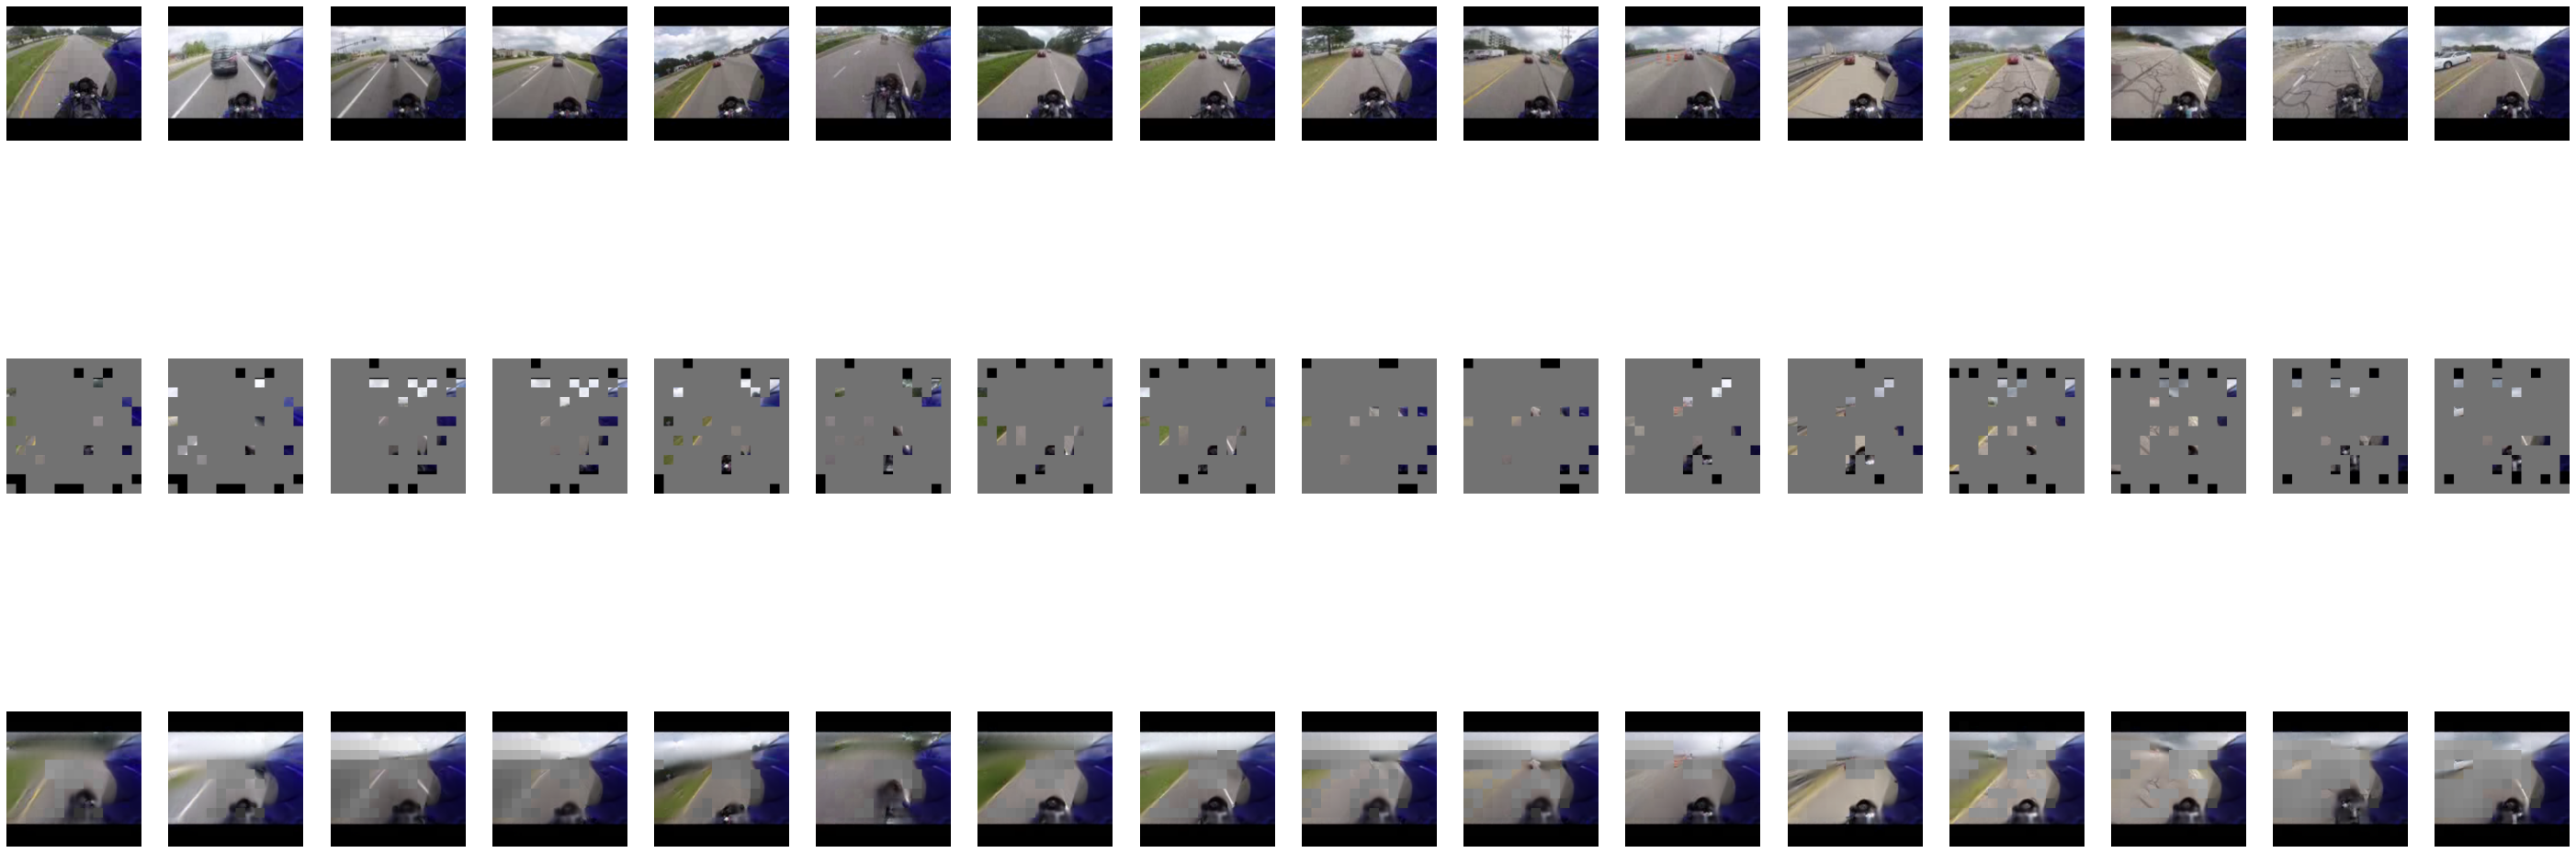

In [ ]:
loss, pred, mask, vis = model(vid.unsqueeze(0), 1, mask_ratio=0.9, visualize=True)
plot_input(vis[0].permute(0, 2, 1, 3, 4))

In [ ]:
import tqdm

num_sample = 500
mask_ratio = 0.993

mse_sum = torch.tensor(np.zeros((8,14,14)))
mask_count = np.zeros((8,14,14))

for i in tqdm.tqdm(range(num_sample)):
  loss, pred, mask, vis = model(vid.unsqueeze(0), 1, mask_ratio=mask_ratio)

  fragment = 1 - (mask.reshape((8,14,14)))
  mask_count = np.add(mask_count, fragment)
  mse_sum = np.add(mse_sum, (fragment * (float)(loss)))

100%|██████████| 500/500 [39:24<00:00,  4.73s/it]


In [ ]:
mask_count += 0.0001 #prevents divide by zero. Introduces bias, will change later

In [ ]:
mse = np.divide(mse_sum, mask_count)

In [ ]:
import pandas as pd

data = pd.Series(mse.flatten())

In [ ]:
data.to_csv("mse_" + str(num_sample) +"_"+ str((int)(1000 * mask_ratio)) + "_-BQwNszotto.csv")

In [ ]:
data.describe()

count    1568.000000
mean        0.859631
std         0.281553
min         0.000000
25%         0.716697
50%         0.845733
75%         1.005016
max         2.058407
dtype: float64

In [ ]:
mse = mse[mse > 0]
top_args = np.argsort(mse.ravel())[:150]
least_args = np.argsort(mse.ravel())[-150:]

In [ ]:
fragment = np.zeros((8,14,14))
for arg in top_args:
  fragment[np.unravel_index((int)(arg), (8,14,14))] = 1
fragment_least = np.zeros((8,14,14))
for arg in least_args:
  fragment_least[np.unravel_index((int)(arg), (8,14,14))] = 1

fragment = scipy.ndimage.zoom(fragment, (2, 16, 16), order=1)
fragment_least = scipy.ndimage.zoom(fragment_least, (2, 16, 16), mode='nearest', order=1)

In [ ]:
heat_video = 0.25 + vid/2
heat_video[0] = np.add(heat_video[0], 3*fragment_least)
heat_video[1] = np.add(heat_video[1], 3*fragment)

In [ ]:
show_video(vid)

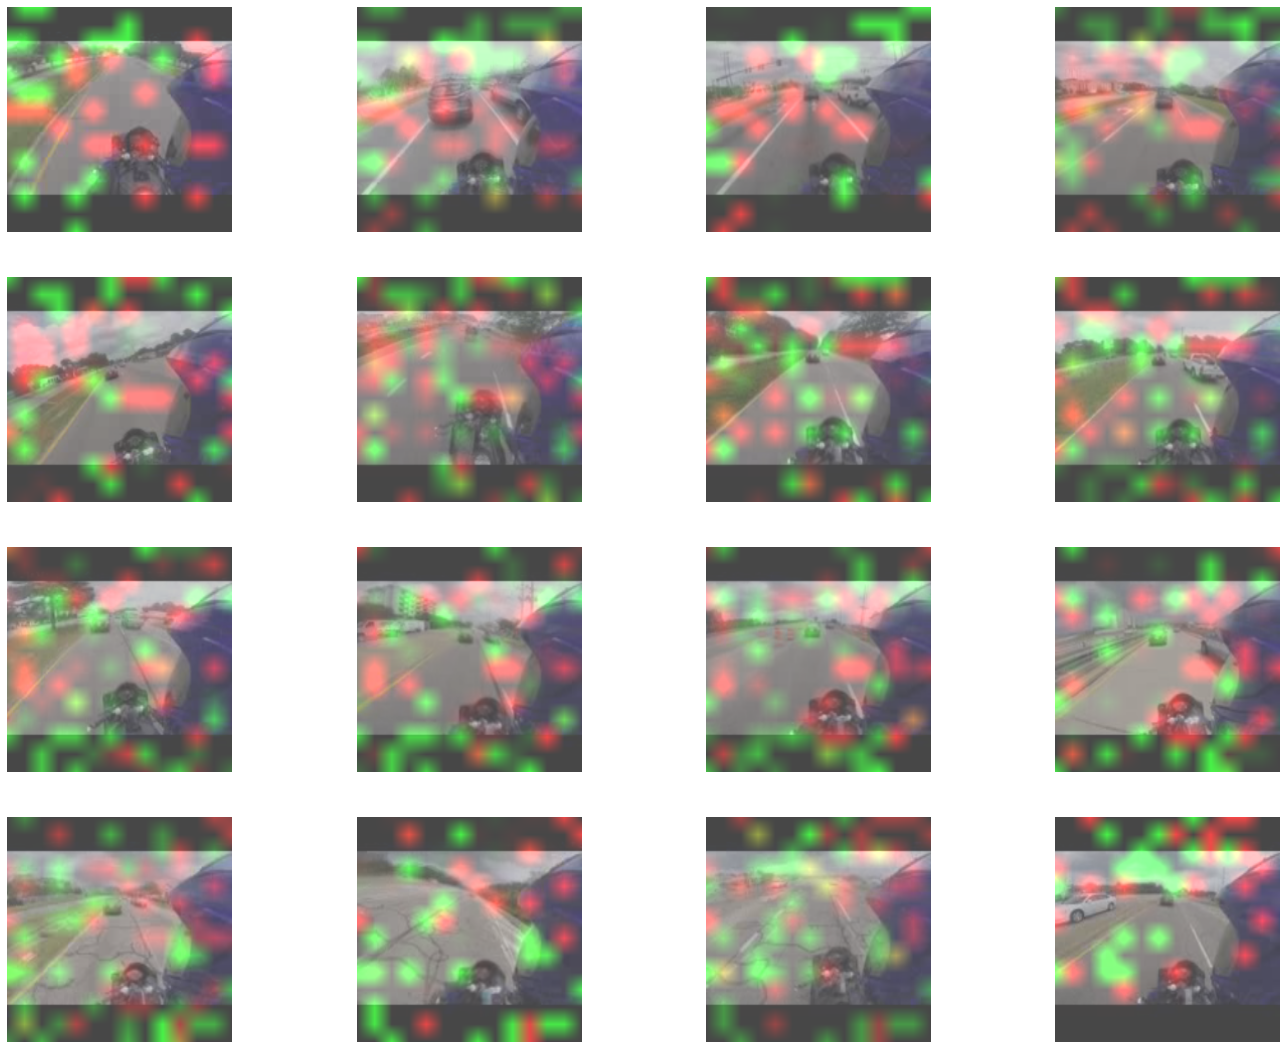

In [ ]:
show_video(heat_video)

In [ ]:
data = pd.read_csv("/content/mse_500_993_-BQwNszotto.csv")
data = data[data > 0]
data.describe()

,Unnamed: 0,0
count,1567.00000,1517.000000
mean,784.00000,0.888531
std,452.49825,0.237157
min,1.00000,0.368529
25%,392.50000,0.726793
50%,784.00000,0.855297
75%,1175.50000,1.012504
max,1567.00000,2.058407
